Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment-20240806/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment-20240806/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,image_size=(img_height, img_width),labels='inferred',validation_split=0.2,subset="training")

Found 3239 files belonging to 9 classes.
Using 2592 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,image_size=(img_height, img_width),labels='inferred',validation_split=0.2,subset="validation")

Found 3239 files belonging to 9 classes.
Using 647 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

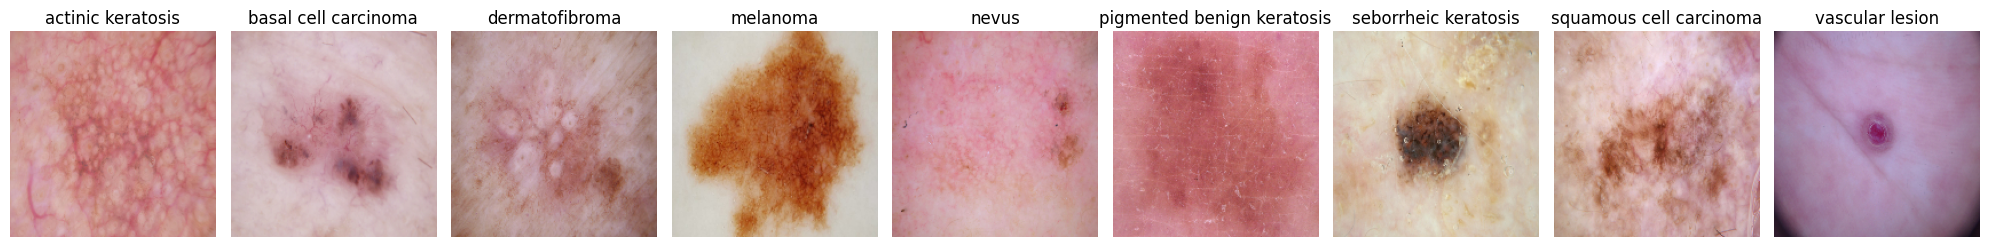

In [ ]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
# Prepare to collect one image per class
class_samples = {class_name: None for class_name in class_names}
# Iterate over dataset and collect one image per class
for images, labels in train_ds:
    for img, lbl in zip(images, labels):
        class_name = class_names[int(lbl)]
        if class_samples[class_name] is None:
            class_samples[class_name] = img
        # Stop once we have samples from all classes
        if all(sample is not None for sample in class_samples.values()):
            break
    if all(sample is not None for sample in class_samples.values()):
        break

# Plot one instance per class
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))
for i, (class_name, img) in enumerate(class_samples.items()):
    axes[i].imshow(img.numpy().astype("uint8"))
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
# Apply rescaling to the dataset
rescale_layer = tf.keras.layers.Rescaling(1./255)
def preprocess_image(image, label):
    image = rescale_layer(image)
    return image, label

train_ds = train_ds.map(preprocess_image)

In [ ]:
# create base model (without Dropout layer)
model = Sequential()

# first conv layer
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(img_height, img_width,3))) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
#model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 495616)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      63,438,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,459,529 (242.08 MB)

 Trainable params: 63,459,529 (242.08 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 495616)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      63,438,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,459,529 (242.08 MB)

 Trainable params: 63,459,529 (242.08 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.2503 - loss: 5.6045 - val_accuracy: 0.3244 - val_loss: 171.5126
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.3928 - loss: 1.6868 - val_accuracy: 0.4653 - val_loss: 141.3838
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4981 - loss: 1.4299 - val_accuracy: 0.4116 - val_loss: 189.9783
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5706 - loss: 1.2406 - val_accuracy: 0.3043 - val_loss: 317.2477
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6411 - loss: 1.0605 - val_accuracy: 0.4049 - val_loss: 157.4893
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6983 - loss: 0.8391 - val_accuracy: 0.2707 - val_loss: 366.8186
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7690 - loss: 0.7186 - val_accuracy: 0.3893 - val_loss: 279.3469
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8048 - loss: 0.5533 - val_accur

### Visualizing training results

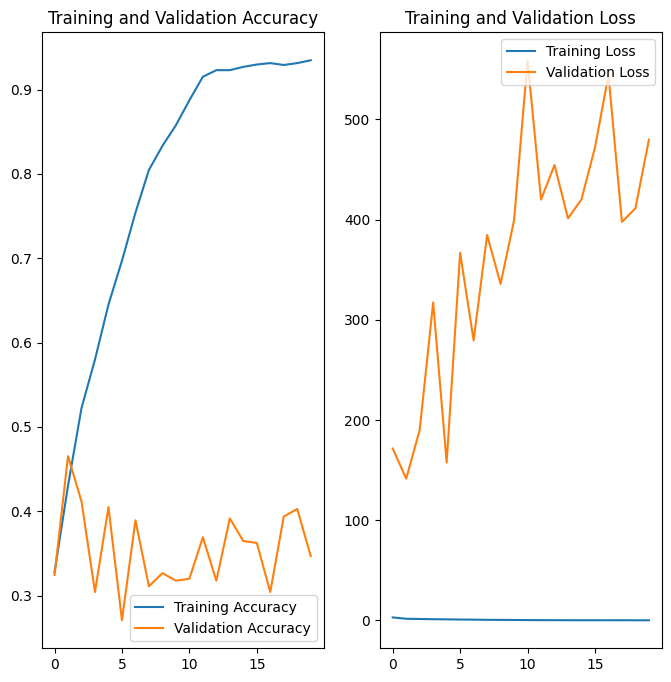

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
Training accuracy is extremely high while validation accuracy is extremely low. This suggests overfitting.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# create model with DROPOUT layer this time
model = Sequential()

# first conv layer
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(img_height, img_width,3))) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 176, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 495616)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      63,438,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,459,529 (242.08 MB)

 Trainable params: 63,459,529 (242.08 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [ ]:
## Your code goes here
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 176, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 495616)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      63,438,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,459,529 (242.08 MB)

 Trainable params: 63,459,529 (242.08 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.2000 - loss: 8.0881 - val_accuracy: 0.4653 - val_loss: 60.2219
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.4142 - loss: 1.6988 - val_accuracy: 0.3669 - val_loss: 131.6266
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.4316 - loss: 1.6055 - val_accuracy: 0.4452 - val_loss: 76.1654
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4961 - loss: 1.5130 - val_accuracy: 0.4519 - val_loss: 91.7555
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5145 - loss: 1.4405 - val_accuracy: 0.4497 - val_loss: 46.1940
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5274 - loss: 1.3253 - val_accuracy: 0.4161 - val_loss: 99.2948
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5829 - loss: 1.1485 - val_accuracy: 0.4698 - val_loss: 102.5164
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6216 - loss: 1.0547 - val_accuracy: 0

### Visualizing the results

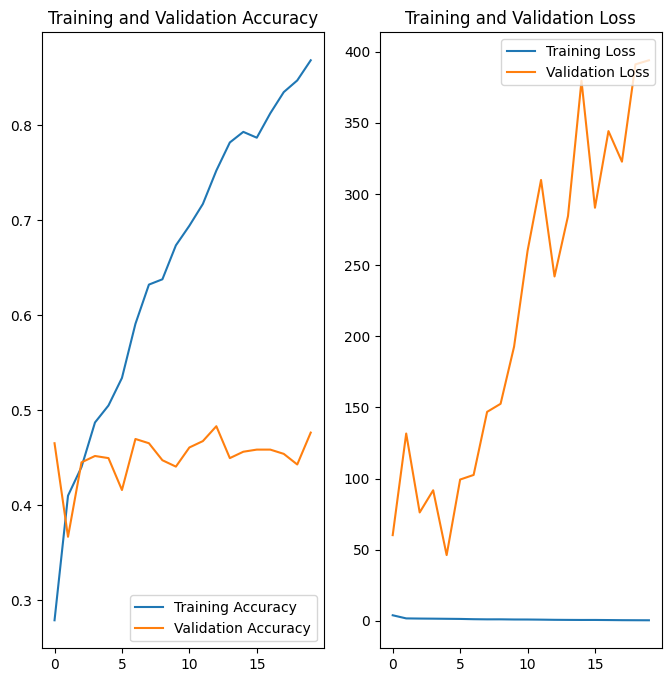

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Validation accuracy has improved a bit after introducing dropout layers.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
class_distribution = {class_name: 0 for class_name in class_names}

for images, labels in train_ds:
    for label in labels.numpy():
        class_distribution[class_names[label]] += 1

print(class_distribution)

{'actinic keratosis': 92, 'basal cell carcinoma': 309, 'dermatofibroma': 77, 'melanoma': 352, 'nevus': 277, 'pigmented benign keratosis': 370, 'seborrheic keratosis': 58, 'squamous cell carcinoma': 142, 'vascular lesion': 115}


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis has least number of samples, 58.
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis dominates with 370 samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D365A70F370>: 100%|██████████| 500/500 [00:25<00:00, 19.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D365A72B9D0>: 100%|██████████| 500/500 [00:19<00:00, 25.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D365BC75270>: 100%|██████████| 500/500 [00:20<00:00, 24.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D365A76A9B0>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7D365B8D8A00>: 100%|██████████| 500/500 [01:23<00:00,  5.99 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D365A78B520>: 100%|██████████| 500/500 [00:19<00:00, 25.58 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D365A728640>: 100%|██████████| 500/500 [00:37<00:00, 13.22 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D36EFDE4C10>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D365A777A30>: 100%|██████████| 500/500 [00:19<00:00, 25.12 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [5]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_973eda3a-a56e-43c6-abc6-bf8bff562f13.jpg',
 '/content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_31cc284f-a6ab-43d9-9e1b-37e7ac775e9f.jpg',
 '/content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_0e63a826-207e-4f61-96c0-51c18e6e1d84.jpg',
 '/content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_2d0397ef-6f36-45f7-b234-560fa0c29597.jpg',
 '/content/gdrive/MyDrive/Backups/CNN_assignment/Skin cancer ISIC The International 

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [ ]:
df2['Label'].value_counts()

Label
actinic keratosis             1000
basal cell carcinoma          1000
melanoma                       500
vascular lesion                500
squamous cell carcinoma        500
nevus                          500
pigmented benign keratosis     500
dermatofibroma                 500
seborrheic keratosis           500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [11]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7739 files belonging to 9 classes.
Using 6192 files for training.


#### **Todo:** Create a validation dataset

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7739 files belonging to 9 classes.
Using 1547 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [12]:
## your code goes here
# create model with DROPOUT layer and Bath Normalization
model = Sequential()

# first conv layer
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(img_height, img_width,3))) # input shape = (img_rows, img_cols, 1)
model.add(BatchNormalization())

# second conv layer
model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 176, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 176, 176, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 495616)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │      63,438,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,459,913 (242.08 MB)

 Trainable params: 63,459,721 (242.08 MB)

 Non-trainable params: 192 (768.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [13]:
## Your code goes here
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer='sgd',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [14]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 1086s 6s/step - accuracy: 0.1923 - loss: 17.1976 - val_accuracy: 0.2172 - val_loss: 2.1148
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 61s 229ms/step - accuracy: 0.2394 - loss: 2.0408 - val_accuracy: 0.2909 - val_loss: 1.8982
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.2674 - loss: 1.9322 - val_accuracy: 0.3833 - val_loss: 1.7985
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.2991 - loss: 1.8535 - val_accuracy: 0.4150 - val_loss: 1.5627
Epoch 5/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 84s 242ms/step - accuracy: 0.3296 - loss: 1.7771 - val_accuracy: 0.3736 - val_loss: 1.8262
Epoch 6/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.3642 - loss: 1.7122 - val_accuracy: 0.3064 - val_loss: 2.8618
Epoch 7/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 224ms/step - accuracy: 0.3659 - loss: 1.7016 - val_accuracy: 0.4809 - val_loss: 1.5017
Epoch 8/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 85s 239ms/step - accuracy: 0.3892 - loss: 1

#### **Todo:**  Visualize the model results

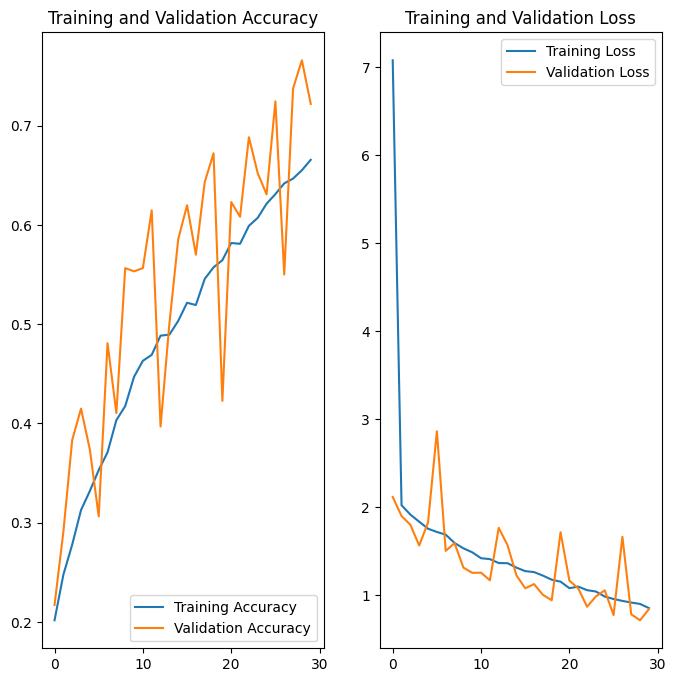

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Class rebalance with augmentation helped. Training and validation accuracy metric values have come closer now to 67, 72% respectively.



In [17]:
# evaluate the model on test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,seed=123,image_size=(img_height, img_width),labels='inferred',validation_split=None,subset=None)
model.evaluate(test_ds)

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.3161 - loss: 2.7286


[2.6901297569274902, 0.347457617521286]

In [18]:
print(model.metrics_names)

['loss', 'compile_metrics']
